deeper FF models have slightly worse performance than recurrent.

In [1]:
from sys import path
from os.path import relpath, realpath, abspath, join, exists
from itertools import product, chain

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

pd.set_option('display.max_rows', 999)

In [2]:
from torchnetjson.builder import build_net

In [3]:
from thesis_v2 import dir_dict
from thesis_v2.data import load_data_helper
from thesis_v2.training.training_aux import load_training_results
# I forgot how this count_params handles BN buffer parameters (running mean and std) looks like it's ignored.
from thesis_v2.training_extra.misc import count_params
from thesis_v2.models.maskcnn_polished_with_rcnn_k_bl.builder import load_modules

load_modules()

In [4]:
from thesis_v2.configs.model.maskcnn_polished_with_rcnn_k_bl import (
    explored_models_20200707 as param_iterator_obj_1,
    explored_models_20200708 as param_iterator_obj_2,
    explored_models_20200709 as param_iterator_obj_3,
#     explored_models_20200705 as param_iterator_obj_2,
    explored_models_20200530_2 as param_iterator_obj_deeper_ff,
    keygen
)

In [5]:
# compute ccmax
from strflab.stats import cc_max
from thesis_v2.data.prepared.yuanyuan_8k import get_neural_data_per_trial

cc_max_all_neurons = cc_max(get_neural_data_per_trial(
    ('042318', '043018','051018',))
                           )
assert cc_max_all_neurons.shape == (79,)

In [6]:
def load_everything():
    _df_collect = []
    for idx, param in enumerate(
        chain(
            param_iterator_obj_1().generate(),
            param_iterator_obj_2().generate(),
            param_iterator_obj_3().generate(),
            param_iterator_obj_deeper_ff().generate(),
        )
    ):
        if idx % 100 == 0:
            print(idx)
            
#         if idx >= 100:
#             break
            
#         print(len(param))
#         print(len(param))

        assert param['kernel_size_l23'] == 3
        if 'yhat_reduce_pick' not in param:
            param['yhat_reduce_pick'] = -1

        assert len(param) == 24
        
        assert param['kernel_size_l1'] == 9
        assert param['ff_1st_block']

        assert param['split_seed'] == 'legacy'
        assert param['pooling_ksize'] == 3
        assert param['pooling_type'] == 'avg'
        assert not param['bn_after_fc']
        assert param['rcnn_bl_psize'] == 1
        assert param['rcnn_bl_ptype'] is None
        assert param['input_size'] == 50
        
        assert param['rcnn_acc_type'] == 'cummean'
        
        # 12 to go
        # remove smoothness_name and scale_name, 10 to go
        
#         assert param['model_seed'] == 0
        
        key = keygen(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
        # 10 to go.
        result = load_training_results(key, return_model=False)
        # load twice, first time to get the model.
        result = load_training_results(key, return_model=True, model=build_net(result['config_extra']['model']))
        num_epochs = [len(x) for x in result['stats_all']]
        
        cc_raw = np.asarray(result['stats_best']['stats']['test']['corr'])
        assert cc_raw.shape == (79,)
        
        if param['train_keep'] is None:
            param['train_keep'] = 5120
        
        _df_collect.append(
            {
                'train_keep': param['train_keep'],
                'act_fn': param['act_fn'],
                'loss_type': param['loss_type'],
                'scale': float(param['scale']),
                'smoothness': float(param['smoothness']),
                'num_layer': param['num_layer'],
                'out_channel': param['out_channel'],
                # 4 to go.
                '1st_bn_before_act': param['ff_1st_bn_before_act'],
                'rcnn_bl_cls': param['rcnn_bl_cls'],
#                 'rcnn_acc_type': param['rcnn_acc_type'],

                'model_seed': param['model_seed'],
                # done,
                'corr_test': ((cc_raw/cc_max_all_neurons)**2).mean(),
                'max_epoch': max(num_epochs),
                'num_param': count_params(result['model']),
            }
        )
    _df =  pd.DataFrame(_df_collect, columns=[
#             'split_seed',
        'train_keep',
        'act_fn',
        'loss_type', 'scale', 'smoothness', 'num_layer',
        'out_channel', '1st_bn_before_act',

        'rcnn_bl_cls',
#         'rcnn_acc_type',
        'model_seed',

        'corr_test',
        'num_param',
        'max_epoch',
    ])
#     print(_df)
    _df = _df.set_index([
        'train_keep',
        'act_fn',
        'loss_type', 'scale', 'smoothness', 'num_layer',
        'out_channel', '1st_bn_before_act',
        'rcnn_bl_cls',
#         'rcnn_acc_type',
        'model_seed',
    ], verify_integrity=True)
    return _df

In [7]:
df = load_everything()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500


In [8]:
corr_mean = df['corr_test'].unstack('model_seed').mean(axis=1)

# mean, max, min, all the same. for num_param
num_param = df['num_param'].unstack('model_seed').mean(axis=1)

In [9]:
# get more quantitive measures. this is necessary for publication.
# I will check each num layer x num channel combinations for cls=1
# and then check cls > 1, num_layer -1 models.

In [10]:
combined_df = pd.concat([corr_mean, num_param], axis=1).rename(columns={0:'corr_mean', 1:'num_param'})

In [11]:
assert combined_df.index.equals(corr_mean.index)
assert combined_df.index.equals(num_param.index)

In [12]:
def get_quantitive_measures_outer_one_case(values):
    assert isinstance(values, np.ndarray) and values.ndim == 1
    return {
        'p25': np.percentile(values, 25),
        'p50': np.percentile(values, 50),
        'p75': np.percentile(values, 75),
        'mean': values.mean(),
        'sem': values.std()/np.sqrt(values.size),
    }

In [13]:
def quantitive_measures_outer(df_this):
    # first get all possible combinations of layer and channel, for cls = 1
    
    cls_1_df = df_this.xs(1, level='rcnn_bl_cls')
    
    cls_1_layers = cls_1_df.index.get_level_values('num_layer')
    cls_1_channels = cls_1_df.index.get_level_values('out_channel')
    cls_1_data_combined = np.asarray([cls_1_layers.values, cls_1_channels.values]).T
    cls_1_layer_c_unique = np.unique(cls_1_data_combined, axis=0)
    print(cls_1_layer_c_unique)
    
    # ok, for each one I will see if there is some cls>1 models to compare with.
    cls_high_df = df_this.loc[df_this.index.get_level_values('rcnn_bl_cls') != 1]
    
    print(cls_1_df.shape, cls_high_df.shape)
    
    df_to_collect = []
    
    for (num_layer_this, num_ch_this) in cls_1_layer_c_unique:
        print(num_layer_this, num_ch_this)
        model_1c = cls_1_df.xs(num_layer_this, level='num_layer').xs(num_ch_this, level='out_channel')
        print(model_1c.shape)
        
        if num_layer_this % 2 == 0:
            print('no matching models!')
            continue
        
        num_layer_high_c = (num_layer_this-1)//2 + 1
        
        if num_layer_high_c not in cls_high_df.index.get_level_values('num_layer'):
            print('no matching models!')
            continue
        
        cls_high_df_matched_layer = cls_high_df.xs(num_layer_high_c, level='num_layer')
        if num_ch_this not in cls_high_df_matched_layer.index.get_level_values('out_channel'):
            print('no matching models!')
            continue
            
        cls_high_df_matched_both = cls_high_df_matched_layer.xs(num_ch_this, level='out_channel')
        print(cls_high_df_matched_both.shape)
        
        
#         model_high_c = df_this.xs(num_layer_this-1, level='num_layer').xs(num_ch_this, level='out_channel')
#         model_high_c = model_high_c.loc[model_high_c.index.get_level_values('rcnn_bl_cls')!=1]
#         print(model_high_c.shape)

        # collect num_param
        num_param_l1_models = model_1c['num_param'].values
        print(num_param_l1_models)
        
        num_param_l_high_models = cls_high_df_matched_both['num_param'].values
        print(num_param_l_high_models)
        
        # insert layer 1 cases.
        # for corr, check p25, p50, p75, mean, std
        shared_part = {
                'num_layer_ff': num_layer_this,
                'num_layer_recurrent': num_layer_high_c,
                'num_ch': num_ch_this,
            }
        
        df_to_collect.append(
            {
            **shared_part,
                **{
                  'cls': 1,  
                },
                **get_quantitive_measures_outer_one_case(
                    model_1c['corr_mean'].values,
                ),
                **{
                    'num_param_mean': num_param_l1_models.mean(),
                }
            }
        )
        
        # get data for cls>1
        for cls_this_one in cls_high_df_matched_both.index.get_level_values('rcnn_bl_cls').unique():
            df_to_collect.append(
            {
            **shared_part,
                **{
                  'cls': cls_this_one,  
                },
                **get_quantitive_measures_outer_one_case(
                    cls_high_df_matched_both.xs(cls_this_one, level='rcnn_bl_cls')['corr_mean'].values,
                ),
                **{
                    'num_param_mean': cls_high_df_matched_both.xs(cls_this_one, level='rcnn_bl_cls')['num_param'].values.mean(),
                }
            }
        )
    df_to_collect = pd.DataFrame(df_to_collect, columns=list(df_to_collect[0].keys()))
    df_to_collect = df_to_collect.set_index(keys=list(shared_part.keys()) + ['cls',], verify_integrity=True)
    return df_to_collect

In [14]:
# let's plot this, p50, mean, and num_param_mean
# on x axis I want to show all labels.

In [15]:
from IPython.display import display

In [16]:
def plot_df_quant_one(data_this, index_ref, title_this, yerr=None, markersize=8):
    data_this = data_this.sort_index()
    assert data_this.index.equals(index_ref)
    
    if yerr is not None:
        yerr = yerr.sort_index()
        assert yerr.index.equals(index_ref)
    assert data_this.shape[1] == 10
    
    plt.close('all')
    
    data_this.plot(figsize=(18,8), title=title_this, linestyle='None', marker='*', yerr=yerr,
                   markersize=markersize)
    plt.show()
    display(data_this)

def plot_df_quant(df_quant_this):
    index_ref = df_quant_this['p50'].unstack('cls').sort_index().index
    print(index_ref)
    # plot num_param
    plot_df_quant_one(df_quant_this['num_param_mean'].unstack('cls'), index_ref, 'num_param_mean')
    
    # p50
    plot_df_quant_one(df_quant_this['p50'].unstack('cls'), index_ref, 'neural prediction p50')
    
    # mean
    plot_df_quant_one(df_quant_this['mean'].unstack('cls'), index_ref, 'neural prediction mean')
    
    
    # mean with sem
    
    plot_df_quant_one(df_quant_this['mean'].unstack('cls'), index_ref, 'neural prediction mean + sem',
                     df_quant_this['sem'].unstack('cls'))

In [17]:

def plot_all_quant():
    for training_size in combined_df.index.get_level_values('train_keep').unique():
        print('training size', training_size)
        measure_df_quant = quantitive_measures_outer(combined_df.xs(training_size, level='train_keep'))
        plot_df_quant(measure_df_quant)
# one can argue that, increasing # of parameter via recurrent is more
# EFFICIENT than via having more layers.

# efficient in terms of performance1/performance2 vs num_param1/num_param2.

# basically, how much performance can, can each unit of parameter increase provide.


# note that the gap between recurrent and FF is bigger with SMALLER training data.
# consistent with the idea that recurrent is a useful prior.

training size 1280
[[ 2  8]
 [ 2 16]
 [ 2 32]
 [ 3  8]
 [ 3 16]
 [ 3 32]
 [ 4  2]
 [ 4  4]
 [ 4  8]
 [ 4 16]
 [ 4 32]
 [ 5  2]
 [ 5  4]
 [ 5  8]
 [ 5 16]
 [ 5 32]
 [ 6  2]
 [ 6  4]
 [ 6  8]
 [ 6 16]
 [ 6 32]]
(168, 2) (432, 2)
2 8
(8, 2)
no matching models!
2 16
(8, 2)
no matching models!
2 32
(8, 2)
no matching models!
3 8
(8, 2)
(72, 2)
[18053. 18045. 18053. 18045. 18053. 18045. 18053. 18045.]
[18053. 18069. 18085. 18101. 18117. 18133. 18149. 18165. 18181. 18045.
 18061. 18077. 18093. 18109. 18125. 18141. 18157. 18173. 18053. 18069.
 18085. 18101. 18117. 18133. 18149. 18165. 18181. 18045. 18061. 18077.
 18093. 18109. 18125. 18141. 18157. 18173. 18053. 18069. 18085. 18101.
 18117. 18133. 18149. 18165. 18181. 18045. 18061. 18077. 18093. 18109.
 18125. 18141. 18157. 18173. 18053. 18069. 18085. 18101. 18117. 18133.
 18149. 18165. 18181. 18045. 18061. 18077. 18093. 18109. 18125. 18141.
 18157. 18173.]
3 16
(8, 2)
(72, 2)
[22845. 22829. 22845. 22829. 22845. 22829. 22845. 22829.]
[22845. 22

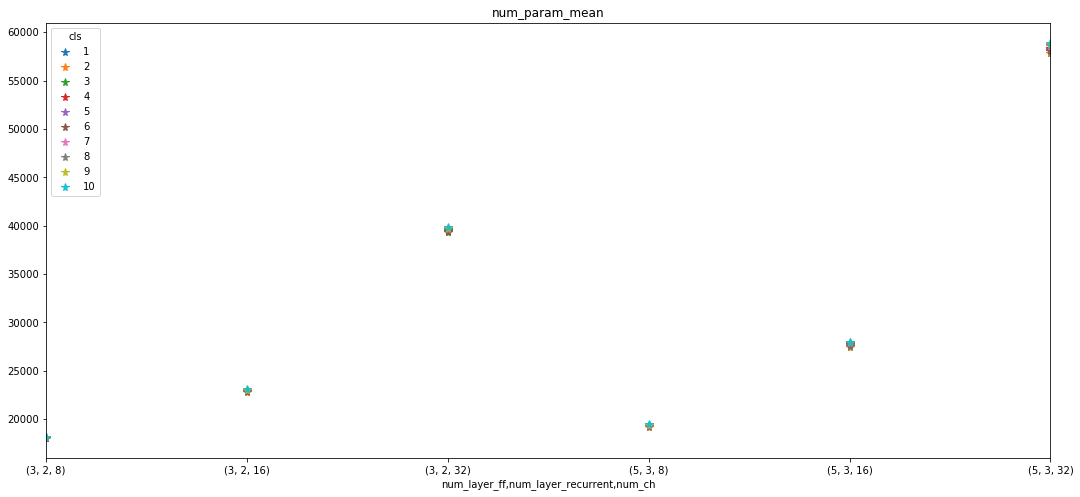

cls                                           1        2        3        4   \
num_layer_ff num_layer_recurrent num_ch                                       
3            2                   8       18049.0  18049.0  18065.0  18081.0   
                                 16      22837.0  22837.0  22869.0  22901.0   
                                 32      39325.0  39325.0  39389.0  39453.0   
5            3                   8       19233.0  19233.0  19265.0  19297.0   
                                 16      27509.0  27509.0  27573.0  27637.0   
                                 32      57885.0  57885.0  58013.0  58141.0   

cls                                           5        6        7        8   \
num_layer_ff num_layer_recurrent num_ch                                       
3            2                   8       18097.0  18113.0  18129.0  18145.0   
                                 16      22933.0  22965.0  22997.0  23029.0   
                                 32      39517.0  39581.0  39645.0  39709.0   
5            3                   8       19329.0  19361.0  19393.0  19425.0   
                                 16      27701.0  27765.0  27829.0  27893.0   
                                 32      58269.0  58397.0  58525.0  58653.0   

cls                                           9        10  
num_layer_ff num_layer_recurrent num_ch                    
3            2                   8       18161.0  18177.0  
                                 16      23061.0  23093.0  
                                 32      39773.0  39837.0  
5            3                   8       19457.0  19489.0  
                                 16      27957.0  28021.0  
                                 32      58781.0  58909.0

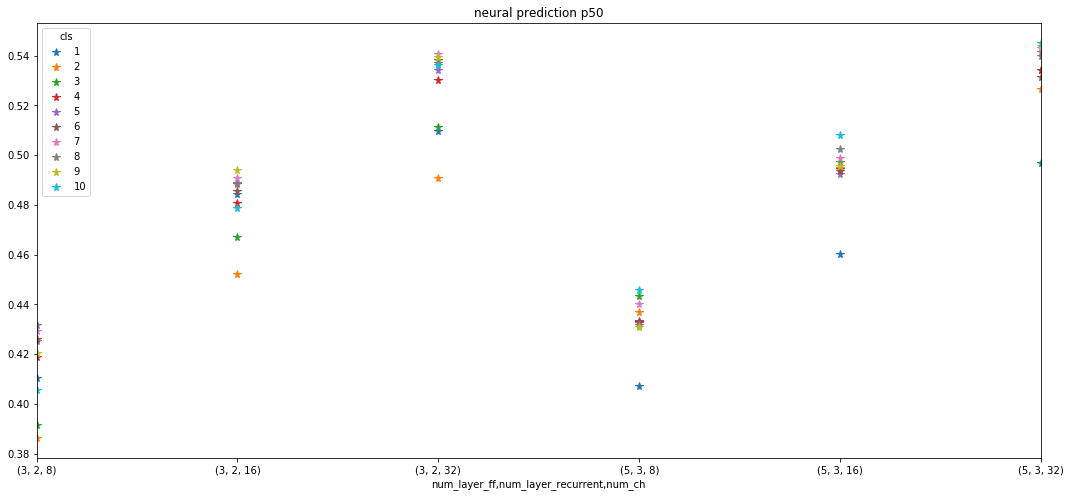

cls                                            1         2         3   \
num_layer_ff num_layer_recurrent num_ch                                 
3            2                   8       0.410256  0.386285  0.391740   
                                 16      0.484508  0.452319  0.467176   
                                 32      0.509587  0.490855  0.511255   
5            3                   8       0.407079  0.437023  0.443366   
                                 16      0.460281  0.494689  0.497200   
                                 32      0.496893  0.526775  0.534434   

cls                                            4         5         6   \
num_layer_ff num_layer_recurrent num_ch                                 
3            2                   8       0.418899  0.425427  0.426091   
                                 16      0.480843  0.488755  0.485771   
                                 32      0.530234  0.534344  0.538377   
5            3                   8       0.433409  0.432700  0.432766   
                                 16      0.494383  0.492364  0.493727   
                                 32      0.534084  0.541285  0.531411   

cls                                            7         8         9   \
num_layer_ff num_layer_recurrent num_ch                                 
3            2                   8       0.429417  0.431640  0.420435   
                                 16      0.490742  0.488411  0.493933   
                                 32      0.540772  0.537033  0.539467   
5            3                   8       0.440060  0.431685  0.430949   
                                 16      0.498910  0.502574  0.495476   
                                 32      0.543117  0.540044  0.544021   

cls                                            10  
num_layer_ff num_layer_recurrent num_ch            
3            2                   8       0.405700  
                                 16      0.478896  
                                 32      0.536128  
5            3                   8       0.445793  
                                 16      0.508160  
                                 32      0.545182

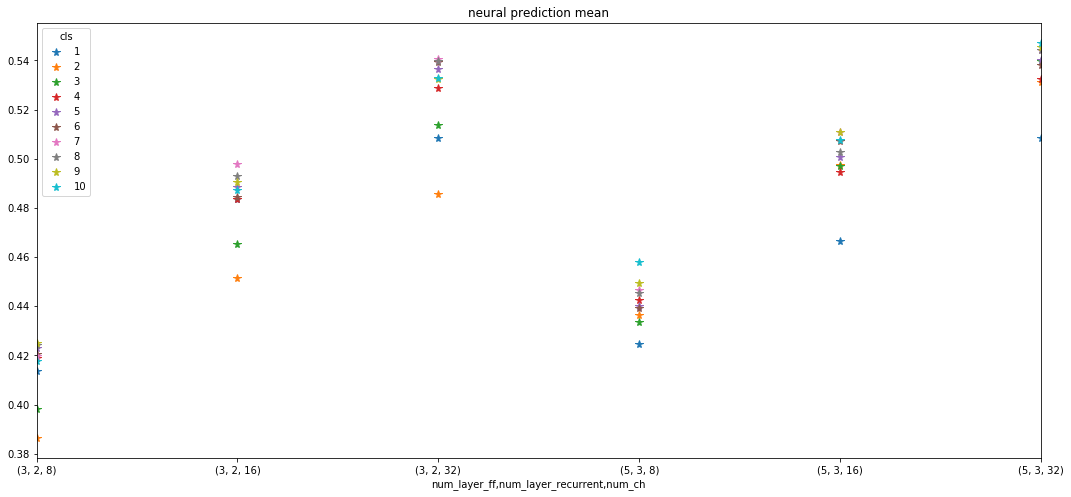

cls                                            1         2         3   \
num_layer_ff num_layer_recurrent num_ch                                 
3            2                   8       0.413749  0.386373  0.398369   
                                 16      0.483553  0.451482  0.465467   
                                 32      0.508522  0.485842  0.513541   
5            3                   8       0.424793  0.436382  0.433731   
                                 16      0.466488  0.497415  0.496952   
                                 32      0.508427  0.531255  0.539588   

cls                                            4         5         6   \
num_layer_ff num_layer_recurrent num_ch                                 
3            2                   8       0.418802  0.423007  0.420586   
                                 16      0.483648  0.488401  0.484581   
                                 32      0.528951  0.536515  0.539210   
5            3                   8       0.442501  0.440053  0.439238   
                                 16      0.494619  0.500800  0.507059   
                                 32      0.532543  0.540257  0.538050   

cls                                            7         8         9   \
num_layer_ff num_layer_recurrent num_ch                                 
3            2                   8       0.419639  0.424244  0.425247   
                                 16      0.497681  0.493144  0.490478   
                                 32      0.540595  0.539722  0.532563   
5            3                   8       0.446472  0.445568  0.449658   
                                 16      0.511007  0.502624  0.510903   
                                 32      0.544052  0.544310  0.545642   

cls                                            10  
num_layer_ff num_layer_recurrent num_ch            
3            2                   8       0.417714  
                                 16      0.487413  
                                 32      0.532785  
5            3                   8       0.457925  
                                 16      0.507686  
                                 32      0.547165

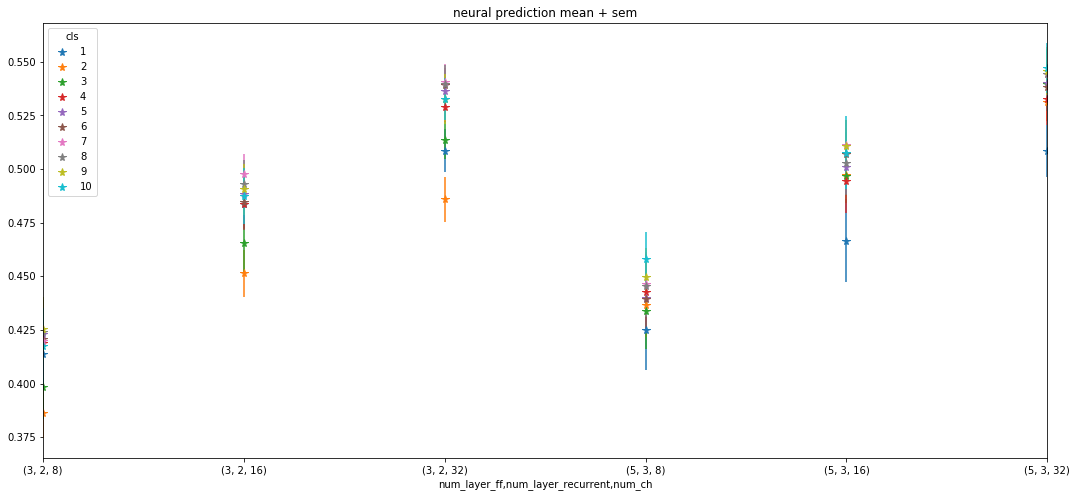

cls                                            1         2         3   \
num_layer_ff num_layer_recurrent num_ch                                 
3            2                   8       0.413749  0.386373  0.398369   
                                 16      0.483553  0.451482  0.465467   
                                 32      0.508522  0.485842  0.513541   
5            3                   8       0.424793  0.436382  0.433731   
                                 16      0.466488  0.497415  0.496952   
                                 32      0.508427  0.531255  0.539588   

cls                                            4         5         6   \
num_layer_ff num_layer_recurrent num_ch                                 
3            2                   8       0.418802  0.423007  0.420586   
                                 16      0.483648  0.488401  0.484581   
                                 32      0.528951  0.536515  0.539210   
5            3                   8       0.442501  0.440053  0.439238   
                                 16      0.494619  0.500800  0.507059   
                                 32      0.532543  0.540257  0.538050   

cls                                            7         8         9   \
num_layer_ff num_layer_recurrent num_ch                                 
3            2                   8       0.419639  0.424244  0.425247   
                                 16      0.497681  0.493144  0.490478   
                                 32      0.540595  0.539722  0.532563   
5            3                   8       0.446472  0.445568  0.449658   
                                 16      0.511007  0.502624  0.510903   
                                 32      0.544052  0.544310  0.545642   

cls                                            10  
num_layer_ff num_layer_recurrent num_ch            
3            2                   8       0.417714  
                                 16      0.487413  
                                 32      0.532785  
5            3                   8       0.457925  
                                 16      0.507686  
                                 32      0.547165

training size 2560
[[ 2  8]
 [ 2 16]
 [ 2 32]
 [ 3  8]
 [ 3 16]
 [ 3 32]
 [ 4  2]
 [ 4  4]
 [ 4  8]
 [ 4 16]
 [ 4 32]
 [ 5  2]
 [ 5  4]
 [ 5  8]
 [ 5 16]
 [ 5 32]
 [ 6  2]
 [ 6  4]
 [ 6  8]
 [ 6 16]
 [ 6 32]]
(168, 2) (432, 2)
2 8
(8, 2)
no matching models!
2 16
(8, 2)
no matching models!
2 32
(8, 2)
no matching models!
3 8
(8, 2)
(72, 2)
[18053. 18045. 18053. 18045. 18053. 18045. 18053. 18045.]
[18053. 18069. 18085. 18101. 18117. 18133. 18149. 18165. 18181. 18045.
 18061. 18077. 18093. 18109. 18125. 18141. 18157. 18173. 18053. 18069.
 18085. 18101. 18117. 18133. 18149. 18165. 18181. 18045. 18061. 18077.
 18093. 18109. 18125. 18141. 18157. 18173. 18053. 18069. 18085. 18101.
 18117. 18133. 18149. 18165. 18181. 18045. 18061. 18077. 18093. 18109.
 18125. 18141. 18157. 18173. 18053. 18069. 18085. 18101. 18117. 18133.
 18149. 18165. 18181. 18045. 18061. 18077. 18093. 18109. 18125. 18141.
 18157. 18173.]
3 16
(8, 2)
(72, 2)
[22845. 22829. 22845. 22829. 22845. 22829. 22845. 22829.]
[22845. 22

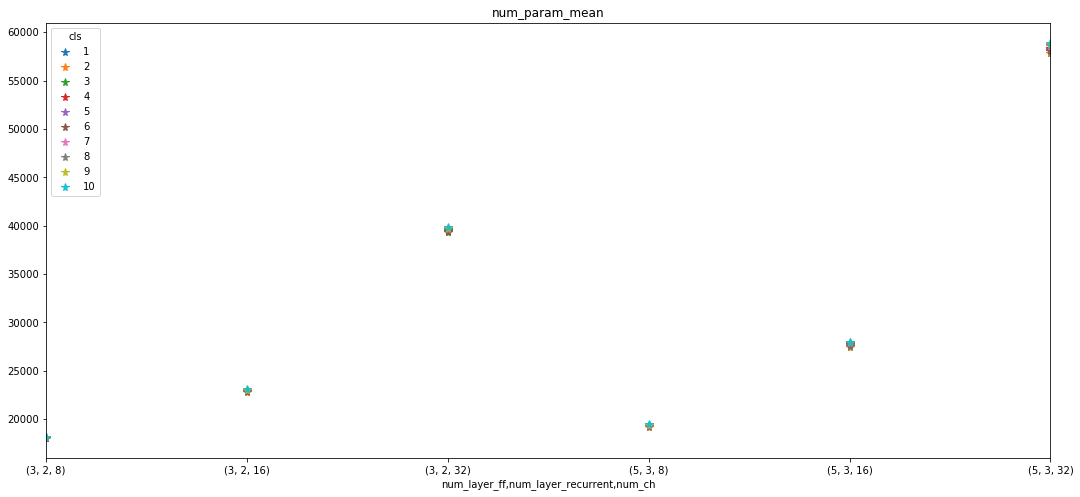

cls                                           1        2        3        4   \
num_layer_ff num_layer_recurrent num_ch                                       
3            2                   8       18049.0  18049.0  18065.0  18081.0   
                                 16      22837.0  22837.0  22869.0  22901.0   
                                 32      39325.0  39325.0  39389.0  39453.0   
5            3                   8       19233.0  19233.0  19265.0  19297.0   
                                 16      27509.0  27509.0  27573.0  27637.0   
                                 32      57885.0  57885.0  58013.0  58141.0   

cls                                           5        6        7        8   \
num_layer_ff num_layer_recurrent num_ch                                       
3            2                   8       18097.0  18113.0  18129.0  18145.0   
                                 16      22933.0  22965.0  22997.0  23029.0   
                                 32      39517.0  39581.0  39645.0  39709.0   
5            3                   8       19329.0  19361.0  19393.0  19425.0   
                                 16      27701.0  27765.0  27829.0  27893.0   
                                 32      58269.0  58397.0  58525.0  58653.0   

cls                                           9        10  
num_layer_ff num_layer_recurrent num_ch                    
3            2                   8       18161.0  18177.0  
                                 16      23061.0  23093.0  
                                 32      39773.0  39837.0  
5            3                   8       19457.0  19489.0  
                                 16      27957.0  28021.0  
                                 32      58781.0  58909.0

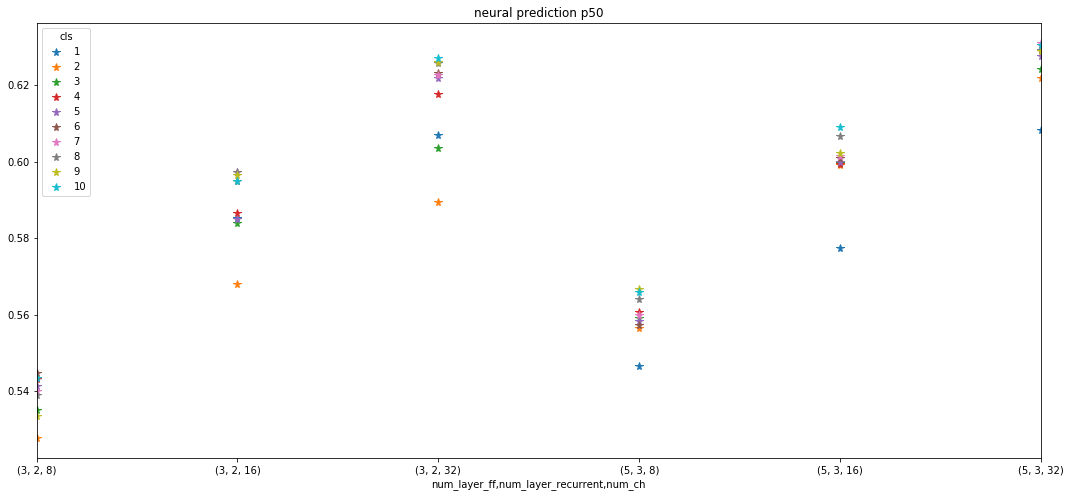

cls                                            1         2         3   \
num_layer_ff num_layer_recurrent num_ch                                 
3            2                   8       0.543411  0.527704  0.535088   
                                 16      0.585256  0.567891  0.583934   
                                 32      0.607126  0.589360  0.603566   
5            3                   8       0.546571  0.556577  0.559026   
                                 16      0.577538  0.599160  0.599668   
                                 32      0.608199  0.621805  0.624336   

cls                                            4         5         6   \
num_layer_ff num_layer_recurrent num_ch                                 
3            2                   8       0.543168  0.541397  0.544736   
                                 16      0.586621  0.584929  0.595049   
                                 32      0.617790  0.621999  0.623227   
5            3                   8       0.560817  0.558453  0.557319   
                                 16      0.599393  0.599924  0.600993   
                                 32      0.629267  0.627720  0.630412   

cls                                            7         8         9   \
num_layer_ff num_layer_recurrent num_ch                                 
3            2                   8       0.539946  0.539086  0.533606   
                                 16      0.597369  0.597409  0.596662   
                                 32      0.622756  0.625775  0.625993   
5            3                   8       0.559872  0.564053  0.566704   
                                 16      0.601381  0.606794  0.602406   
                                 32      0.631119  0.629197  0.629014   

cls                                            10  
num_layer_ff num_layer_recurrent num_ch            
3            2                   8       0.543456  
                                 16      0.594896  
                                 32      0.627223  
5            3                   8       0.565933  
                                 16      0.609116  
                                 32      0.630548

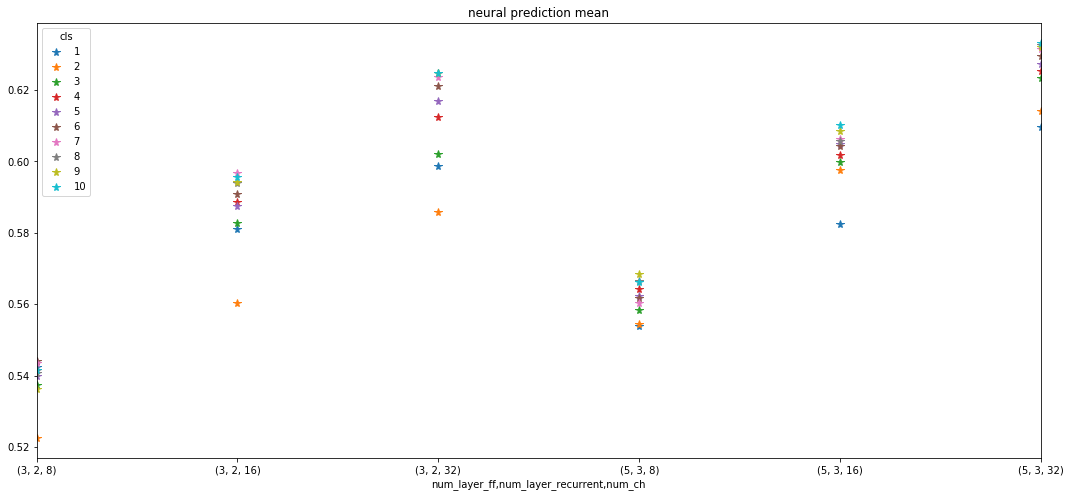

cls                                            1         2         3   \
num_layer_ff num_layer_recurrent num_ch                                 
3            2                   8       0.542347  0.522498  0.537268   
                                 16      0.581176  0.560322  0.582847   
                                 32      0.598788  0.585916  0.602086   
5            3                   8       0.553814  0.554484  0.558409   
                                 16      0.582336  0.597582  0.599675   
                                 32      0.609539  0.614210  0.623307   

cls                                            4         5         6   \
num_layer_ff num_layer_recurrent num_ch                                 
3            2                   8       0.541440  0.539770  0.544180   
                                 16      0.588581  0.587602  0.590930   
                                 32      0.612359  0.616775  0.621115   
5            3                   8       0.564301  0.562201  0.561758   
                                 16      0.601660  0.604785  0.604361   
                                 32      0.625204  0.627203  0.629437   

cls                                            7         8         9   \
num_layer_ff num_layer_recurrent num_ch                                 
3            2                   8       0.543569  0.540703  0.536221   
                                 16      0.596668  0.593843  0.594217   
                                 32      0.623558  0.624753  0.624762   
5            3                   8       0.560352  0.566619  0.568394   
                                 16      0.606305  0.605640  0.608398   
                                 32      0.631380  0.632558  0.631918   

cls                                            10  
num_layer_ff num_layer_recurrent num_ch            
3            2                   8       0.541465  
                                 16      0.595738  
                                 32      0.624755  
5            3                   8       0.566285  
                                 16      0.610110  
                                 32      0.633194

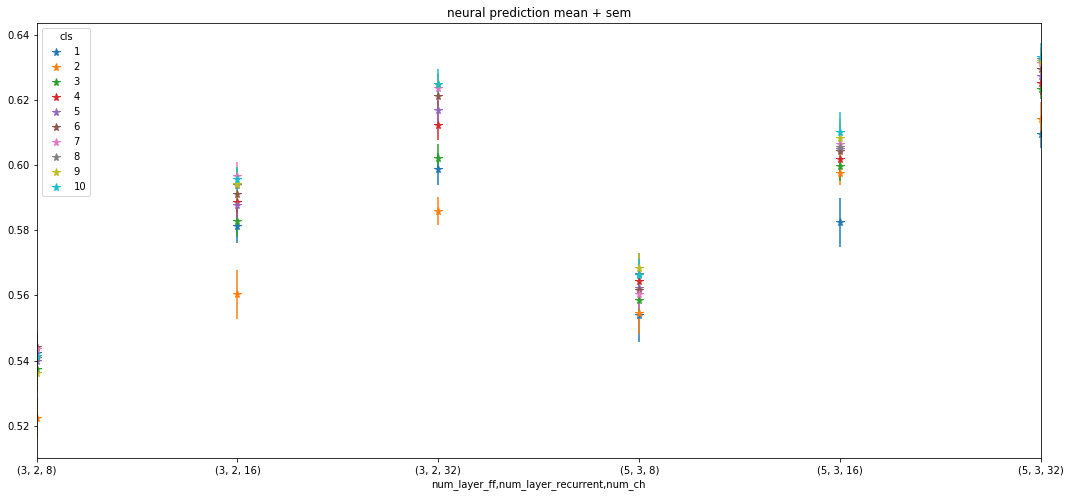

cls                                            1         2         3   \
num_layer_ff num_layer_recurrent num_ch                                 
3            2                   8       0.542347  0.522498  0.537268   
                                 16      0.581176  0.560322  0.582847   
                                 32      0.598788  0.585916  0.602086   
5            3                   8       0.553814  0.554484  0.558409   
                                 16      0.582336  0.597582  0.599675   
                                 32      0.609539  0.614210  0.623307   

cls                                            4         5         6   \
num_layer_ff num_layer_recurrent num_ch                                 
3            2                   8       0.541440  0.539770  0.544180   
                                 16      0.588581  0.587602  0.590930   
                                 32      0.612359  0.616775  0.621115   
5            3                   8       0.564301  0.562201  0.561758   
                                 16      0.601660  0.604785  0.604361   
                                 32      0.625204  0.627203  0.629437   

cls                                            7         8         9   \
num_layer_ff num_layer_recurrent num_ch                                 
3            2                   8       0.543569  0.540703  0.536221   
                                 16      0.596668  0.593843  0.594217   
                                 32      0.623558  0.624753  0.624762   
5            3                   8       0.560352  0.566619  0.568394   
                                 16      0.606305  0.605640  0.608398   
                                 32      0.631380  0.632558  0.631918   

cls                                            10  
num_layer_ff num_layer_recurrent num_ch            
3            2                   8       0.541465  
                                 16      0.595738  
                                 32      0.624755  
5            3                   8       0.566285  
                                 16      0.610110  
                                 32      0.633194

training size 5120
[[ 2  8]
 [ 2 16]
 [ 2 32]
 [ 3  8]
 [ 3 16]
 [ 3 32]
 [ 4  2]
 [ 4  4]
 [ 4  8]
 [ 4 16]
 [ 4 32]
 [ 5  2]
 [ 5  4]
 [ 5  8]
 [ 5 16]
 [ 5 32]
 [ 6  2]
 [ 6  4]
 [ 6  8]
 [ 6 16]
 [ 6 32]]
(168, 2) (432, 2)
2 8
(8, 2)
no matching models!
2 16
(8, 2)
no matching models!
2 32
(8, 2)
no matching models!
3 8
(8, 2)
(72, 2)
[18053. 18045. 18053. 18045. 18053. 18045. 18053. 18045.]
[18053. 18069. 18085. 18101. 18117. 18133. 18149. 18165. 18181. 18045.
 18061. 18077. 18093. 18109. 18125. 18141. 18157. 18173. 18053. 18069.
 18085. 18101. 18117. 18133. 18149. 18165. 18181. 18045. 18061. 18077.
 18093. 18109. 18125. 18141. 18157. 18173. 18053. 18069. 18085. 18101.
 18117. 18133. 18149. 18165. 18181. 18045. 18061. 18077. 18093. 18109.
 18125. 18141. 18157. 18173. 18053. 18069. 18085. 18101. 18117. 18133.
 18149. 18165. 18181. 18045. 18061. 18077. 18093. 18109. 18125. 18141.
 18157. 18173.]
3 16
(8, 2)
(72, 2)
[22845. 22829. 22845. 22829. 22845. 22829. 22845. 22829.]
[22845. 22

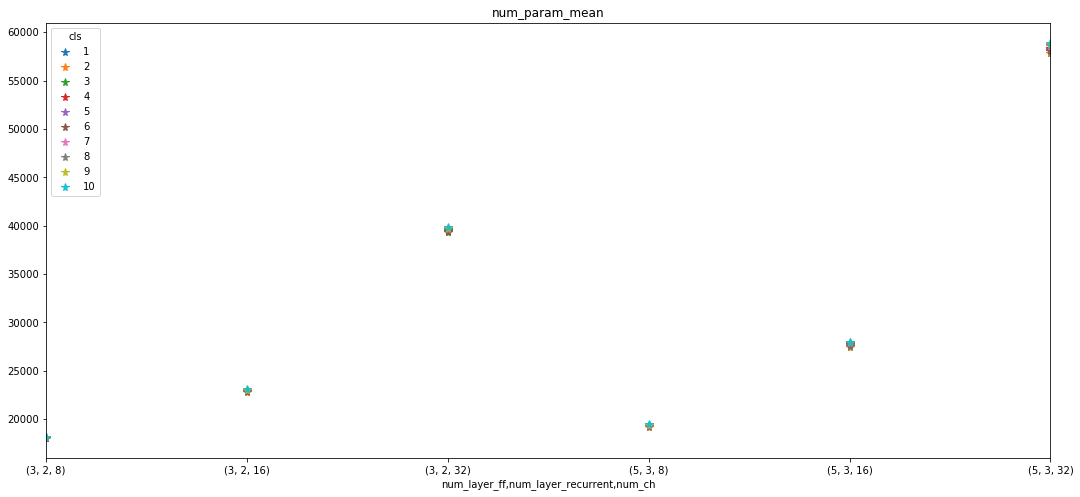

cls                                           1        2        3        4   \
num_layer_ff num_layer_recurrent num_ch                                       
3            2                   8       18049.0  18049.0  18065.0  18081.0   
                                 16      22837.0  22837.0  22869.0  22901.0   
                                 32      39325.0  39325.0  39389.0  39453.0   
5            3                   8       19233.0  19233.0  19265.0  19297.0   
                                 16      27509.0  27509.0  27573.0  27637.0   
                                 32      57885.0  57885.0  58013.0  58141.0   

cls                                           5        6        7        8   \
num_layer_ff num_layer_recurrent num_ch                                       
3            2                   8       18097.0  18113.0  18129.0  18145.0   
                                 16      22933.0  22965.0  22997.0  23029.0   
                                 32      39517.0  39581.0  39645.0  39709.0   
5            3                   8       19329.0  19361.0  19393.0  19425.0   
                                 16      27701.0  27765.0  27829.0  27893.0   
                                 32      58269.0  58397.0  58525.0  58653.0   

cls                                           9        10  
num_layer_ff num_layer_recurrent num_ch                    
3            2                   8       18161.0  18177.0  
                                 16      23061.0  23093.0  
                                 32      39773.0  39837.0  
5            3                   8       19457.0  19489.0  
                                 16      27957.0  28021.0  
                                 32      58781.0  58909.0

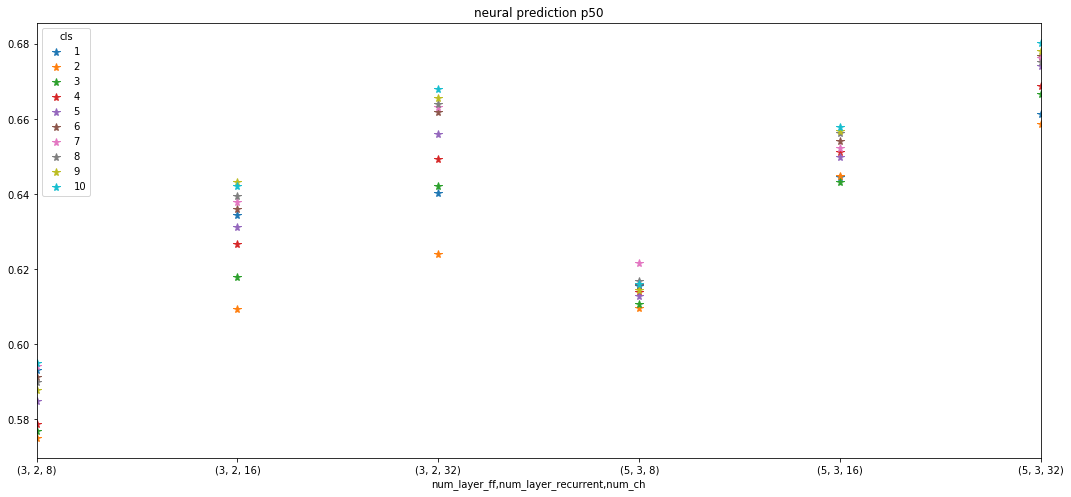

cls                                            1         2         3   \
num_layer_ff num_layer_recurrent num_ch                                 
3            2                   8       0.593060  0.575023  0.576946   
                                 16      0.634606  0.609502  0.617908   
                                 32      0.640310  0.624117  0.642131   
5            3                   8       0.615509  0.609675  0.610869   
                                 16      0.644615  0.644890  0.643267   
                                 32      0.661481  0.658620  0.666777   

cls                                            4         5         6   \
num_layer_ff num_layer_recurrent num_ch                                 
3            2                   8       0.578821  0.584857  0.591228   
                                 16      0.626640  0.631349  0.636118   
                                 32      0.649307  0.656147  0.661984   
5            3                   8       0.613840  0.612910  0.615789   
                                 16      0.651327  0.649898  0.654141   
                                 32      0.668814  0.674280  0.676745   

cls                                            7         8         9   \
num_layer_ff num_layer_recurrent num_ch                                 
3            2                   8       0.594341  0.589909  0.587958   
                                 16      0.637885  0.639628  0.643202   
                                 32      0.663170  0.664166  0.665702   
5            3                   8       0.621815  0.616869  0.614600   
                                 16      0.652462  0.656377  0.656812   
                                 32      0.676319  0.675319  0.678237   

cls                                            10  
num_layer_ff num_layer_recurrent num_ch            
3            2                   8       0.595115  
                                 16      0.642094  
                                 32      0.668140  
5            3                   8       0.616028  
                                 16      0.657952  
                                 32      0.680401

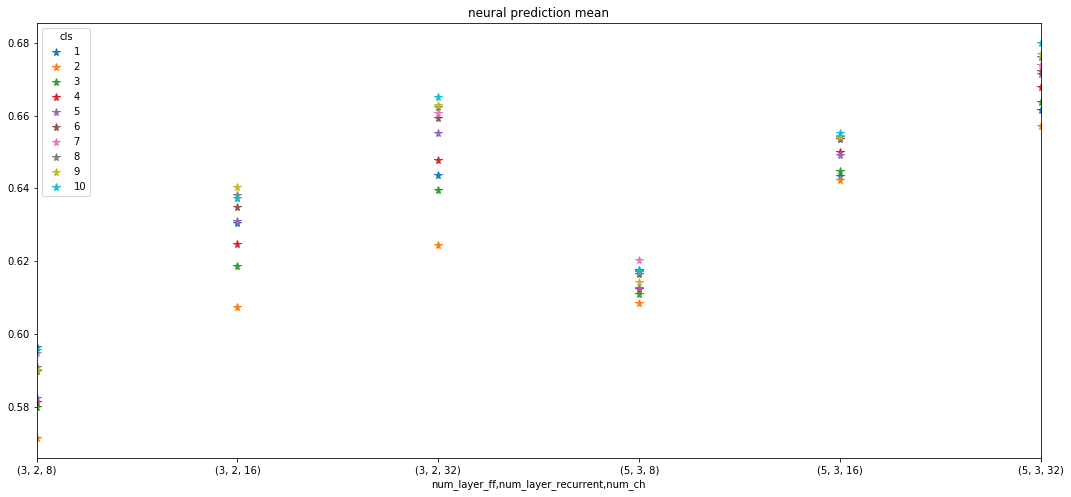

cls                                            1         2         3   \
num_layer_ff num_layer_recurrent num_ch                                 
3            2                   8       0.596350  0.571330  0.579767   
                                 16      0.630568  0.607343  0.618705   
                                 32      0.643770  0.624359  0.639433   
5            3                   8       0.617661  0.608391  0.610849   
                                 16      0.643496  0.642334  0.644798   
                                 32      0.661392  0.657188  0.663766   

cls                                            4         5         6   \
num_layer_ff num_layer_recurrent num_ch                                 
3            2                   8       0.581352  0.582486  0.589855   
                                 16      0.624665  0.630917  0.634958   
                                 32      0.647748  0.655283  0.659399   
5            3                   8       0.612320  0.612500  0.616518   
                                 16      0.649903  0.649232  0.653650   
                                 32      0.667739  0.671353  0.672169   

cls                                            7         8         9   \
num_layer_ff num_layer_recurrent num_ch                                 
3            2                   8       0.594689  0.590882  0.590089   
                                 16      0.637412  0.638199  0.640318   
                                 32      0.660635  0.662324  0.662783   
5            3                   8       0.620409  0.617067  0.614168   
                                 16      0.654181  0.653998  0.654429   
                                 32      0.674013  0.675979  0.676786   

cls                                            10  
num_layer_ff num_layer_recurrent num_ch            
3            2                   8       0.595493  
                                 16      0.637401  
                                 32      0.665009  
5            3                   8       0.617223  
                                 16      0.655263  
                                 32      0.679988

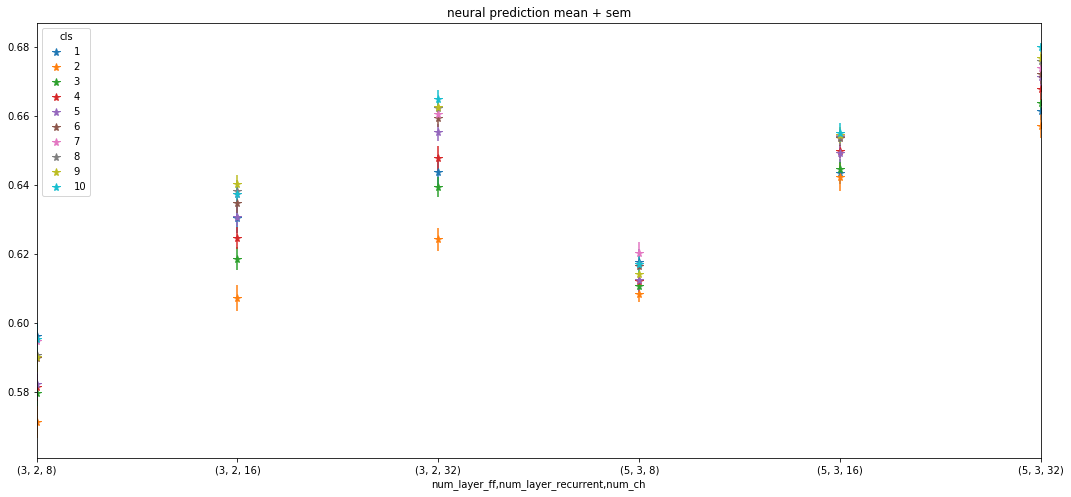

cls                                            1         2         3   \
num_layer_ff num_layer_recurrent num_ch                                 
3            2                   8       0.596350  0.571330  0.579767   
                                 16      0.630568  0.607343  0.618705   
                                 32      0.643770  0.624359  0.639433   
5            3                   8       0.617661  0.608391  0.610849   
                                 16      0.643496  0.642334  0.644798   
                                 32      0.661392  0.657188  0.663766   

cls                                            4         5         6   \
num_layer_ff num_layer_recurrent num_ch                                 
3            2                   8       0.581352  0.582486  0.589855   
                                 16      0.624665  0.630917  0.634958   
                                 32      0.647748  0.655283  0.659399   
5            3                   8       0.612320  0.612500  0.616518   
                                 16      0.649903  0.649232  0.653650   
                                 32      0.667739  0.671353  0.672169   

cls                                            7         8         9   \
num_layer_ff num_layer_recurrent num_ch                                 
3            2                   8       0.594689  0.590882  0.590089   
                                 16      0.637412  0.638199  0.640318   
                                 32      0.660635  0.662324  0.662783   
5            3                   8       0.620409  0.617067  0.614168   
                                 16      0.654181  0.653998  0.654429   
                                 32      0.674013  0.675979  0.676786   

cls                                            10  
num_layer_ff num_layer_recurrent num_ch            
3            2                   8       0.595493  
                                 16      0.637401  
                                 32      0.665009  
5            3                   8       0.617223  
                                 16      0.655263  
                                 32      0.679988

In [18]:
plot_all_quant()